In [1]:
import sys
import os, sys, tarfile
import numpy as np
import matplotlib.pyplot as plt
import urllib
from PIL import Image
from keras.optimizers import RMSprop, SGD

from keras.models import load_model
import keras.backend as K
import data_preprocessing, data_generator, visual, label_parser, data_postprocessing, evaluator
import pdb
import tensorflow as tf

config = tf.ConfigProto()    #to limit TensorFlow resources
config.gpu_options.allow_growth = True
tf.Session(config = config)

%matplotlib inline

%load_ext autoreload
%autoreload 2

C:\Users\Vital\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
TRAIN_PATH = '../udacity_driving_datasets/'
TEST_PATH = '../udacity_driving_datasets/'

In [3]:
train_ann = label_parser.parse_annotation_json(TRAIN_PATH, 'labels_train.json')
test_ann = label_parser.parse_annotation_json(TEST_PATH, 'labels_val.json')
print("len(train_ann) = ",len(train_ann))
print("len(test_ann) = ", len(test_ann))

len(train_ann) =  16217
len(test_ann) =  833


In [4]:
size = 300
config_test  = {'grid_w':9, 'grid_h':9, 'img_w' : size, 'img_h' : size, 'is_augment' : False, 'batch_size' : len(test_ann)}
GRID_W = config_test['grid_w']
GRID_H = config_test['grid_h']
input_w = config_test['img_w']
input_h = config_test['img_h']
testGenerator = data_generator.BatchGenerator(test_ann, config_test)

iteration_num =  1


In [5]:
import tensorflow as tf
def YOLO_loss(y_true, y_pred):
    mask_obj = K.expand_dims(y_true[..., 0], axis=-1)
    mask_no_obj = 1 - mask_obj
    loss_obj = K.sum(K.square(y_true-y_pred)*mask_obj)                             #Loss_xywhp for object
    loss_no_obj = K.sum(K.square(y_true[...,0]-y_pred[...,0])*mask_no_obj[...,0] ) #only confidence
    N_obj = tf.reduce_sum(tf.to_float(mask_obj > 0.0))
    N_no_obj = tf.reduce_sum(tf.to_float(mask_no_obj > 0.0))
    return loss_obj / (N_obj + 1e-06) + 5 * loss_no_obj / (N_no_obj + 1e-06)       #because only 1 from 5 values (p,x,y,w,h)

In [6]:
from keras.utils.generic_utils import get_custom_objects
from keras.models import load_model
get_custom_objects().update({"YOLO_loss": YOLO_loss})
model = load_model("model_udacity_ap_366.h5", custom_objects={ 'loss': YOLO_loss } )

In [7]:
def add_chunk(indices, y_GT, y_pred):
    x_chunk, y_chunk = testGenerator.get_XY(indices)
    y_GT += [y_chunk]
    y_pred += [model.predict(x_chunk)]
y_GT   = []
y_pred = []                         # we add to 'y_pred' data by chunk because of memory limitation
chunk_size = 50                     # we get 'chunk_size' images and forward pass the model on them
N = len(test_ann)                   # images number for to evaluaet mAP
num_of_chunk = int(N / chunk_size)
for i in range(num_of_chunk):
    indices = np.array(range(i*chunk_size, (i+1)*chunk_size))
    add_chunk(indices, y_GT, y_pred)
    print("predicted images (" + str(i*chunk_size) + " - " + str((i+1)*chunk_size) + ")")
if num_of_chunk * chunk_size < N:
    indices = np.array(range(num_of_chunk * chunk_size, N ))
    add_chunk(indices, y_GT, y_pred)
    print("predicted images (" + str(num_of_chunk * chunk_size) + " - " + str(N) + ")")

predicted images (0 - 50)
predicted images (50 - 100)
predicted images (100 - 150)
predicted images (150 - 200)
predicted images (200 - 250)
predicted images (250 - 300)
predicted images (300 - 350)
predicted images (350 - 400)
predicted images (400 - 450)
predicted images (450 - 500)
predicted images (500 - 550)
predicted images (550 - 600)
predicted images (600 - 650)
predicted images (650 - 700)
predicted images (700 - 750)
predicted images (750 - 800)
predicted images (800 - 833)


In [8]:
#merge chunks to shape : y[i] = output
y_pred_reshaped = np.zeros((N, GRID_W, GRID_H, 4+1) )
y_GT_reshaped = np.zeros( (N, GRID_W, GRID_H, 4+1) )
y_pred = np.array(y_pred)
y_GT = np.array(y_GT)
last_ind = 0
for i in range(len(y_pred)): 
    size = len(y_pred[i])  
    y_pred_reshaped[last_ind:last_ind+size] = y_pred[i][:]
    y_GT_reshaped[last_ind:last_ind+size] = y_GT[i][:]
    last_ind += size

In [9]:
y_pred_reshaped.shape

(833, 9, 9, 5)

In [10]:
decoder = data_postprocessing.Encoder(GRID_W, GRID_H, input_w, input_h, 0.3)
pred_rects_encoded, scores = decoder.encode(y_pred_reshaped)
GT_rects_encoded  = decoder.encode_GT(y_GT_reshaped)

In [11]:
scores[3]

array([1.12422645, 1.0226264 , 0.91447717, 0.74360609, 0.74089164,
       0.55777287, 0.53000474])

In [12]:
pred_boxes = {}
gt_boxes = {}
for i in range(len(scores) ):
    pred_boxes[str(i)] = {}
    pred_boxes[str(i)]['boxes'] = pred_rects_encoded[i]
    pred_boxes[str(i)]['scores'] = scores[i]
    gt_boxes[str(i)] = GT_rects_encoded[i]
    
res = evaluator.get_avg_precision_at_iou(gt_boxes,pred_boxes, 0.5)
ap = res['avg_prec']
prec = res['precisions']
recall = res['recalls']
print("ap = %.3f"%ap)

ap = 0.360


In [ ]:
ap = 0.371

In [7]:
x_batch, y_batch = testGenerator.__getitem__(0)
img_num = 2
y_pred = model.predict(x_batch)
np.set_printoptions(precision=3, suppress = True)

print(y_pred[0,:,:,0])

[[-0.058  0.043 -0.068 -0.006  0.014 -0.005 -0.031 -0.056 -0.016]
 [-0.089 -0.113  0.042 -0.101  0.006 -0.003 -0.077 -0.062 -0.009]
 [ 0.015 -0.128  0.015 -0.06   0.046 -0.046 -0.042  0.073  0.022]
 [ 0.045 -0.127 -0.139 -0.057  0.037 -0.003  0.033  0.033  0.082]
 [ 0.764  0.977  1.037  0.504 -0.214 -0.325  0.606  0.307  0.127]
 [ 0.087 -0.015  0.156 -0.101  0.121 -0.01   0.183 -0.049  0.035]
 [ 0.117  0.084 -0.148  0.003  0.067 -0.033 -0.009  0.03  -0.066]
 [ 0.056  0.078 -0.03   0.024 -0.079 -0.027  0.021 -0.002 -0.008]
 [ 0.008  0.007 -0.051 -0.006 -0.059 -0.095 -0.003  0.014  0.101]]


In [15]:
y_pred.shape

(100, 9, 9, 5)

In [8]:
y_batch[0,:,:,0]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [9]:
decoder = data_postprocessing.Encoder(GRID_W, GRID_H, input_w, input_h, 0.5)

In [10]:
pred_rects_encoded, scores = decoder.encode(y_pred)
GT_rects_encoded  = decoder.encode_GT(y_batch)

In [11]:
#convert pred_rects_encoded, scores to format 'img_id' -> {'boxes':[box], 'rects': [rect]}
#GT_rects_encoded to format 'img_id' -> [box]
#
pred_boxes = {}
gt_boxes = {}
for i in range(len(scores) ):
    pred_boxes[str(i)] = {}
    pred_boxes[str(i)]['boxes'] = pred_rects_encoded[i]
    pred_boxes[str(i)]['scores'] = scores[i]
    gt_boxes[str(i)] = GT_rects_encoded[i]

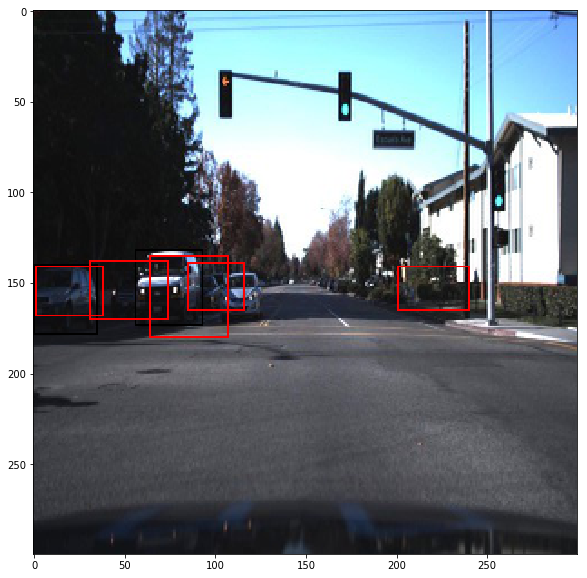

In [12]:
test_image = x_batch[0]*255.0

plt.rcParams['figure.figsize'] = 10, 10


plt.imshow(visual.draw_image_pred_GT(test_image, GT_rects_encoded[0], pred_rects_encoded[0]) )
# plt.imshow(visual.draw_image_pred_GT(test_image, rects_GT) )

In [13]:
res = evaluator.get_avg_precision_at_iou(gt_boxes,pred_boxes, 0.5)

In [14]:
ap = res['avg_prec']
prec = res['precisions']
recall = res['recalls']
print("ap = %.3f"%ap)

ap = 0.366


"YOLO1_scratch_multi_obj" - ap=0.752
"YOLO1_scratch_multi_obj_light" - ap = 0.654
"YOLO_scratch" - ap = 0.763
"YOLO_scratch112" - ap = 0.666

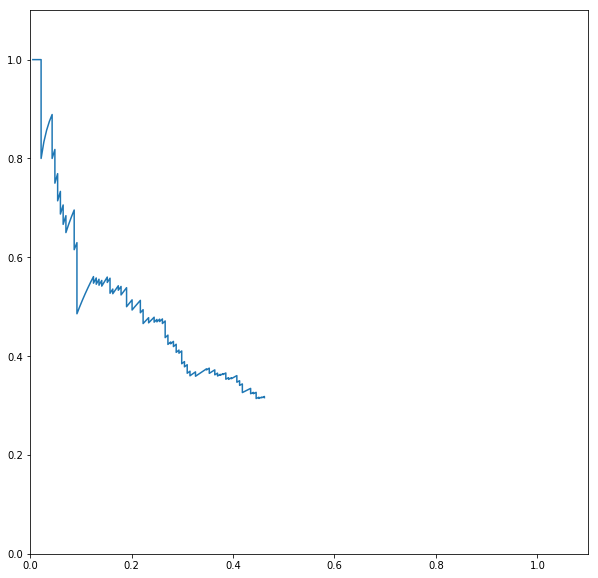

In [29]:
ax = plt.gca()

ax.set_xlim([0.0,1.1])
ax.set_ylim([0.0,1.1])
plt.plot(recall,prec)
plt.figure(figsize=(5,4))


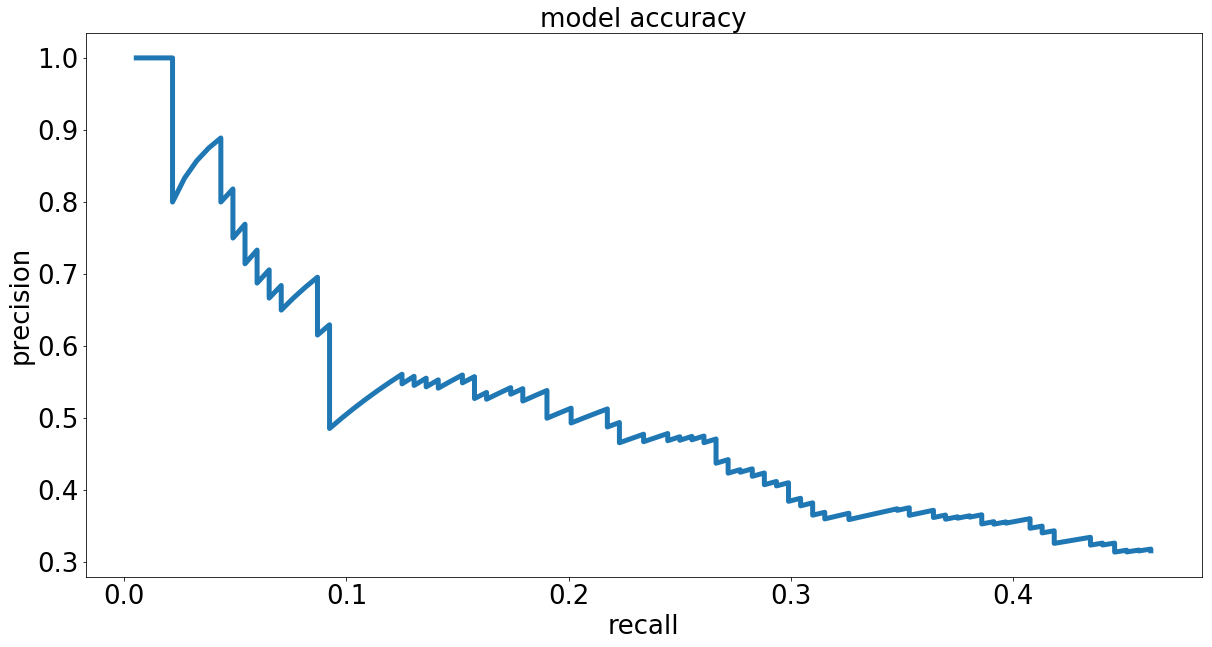

NameError: name 'LeNet' is not defined

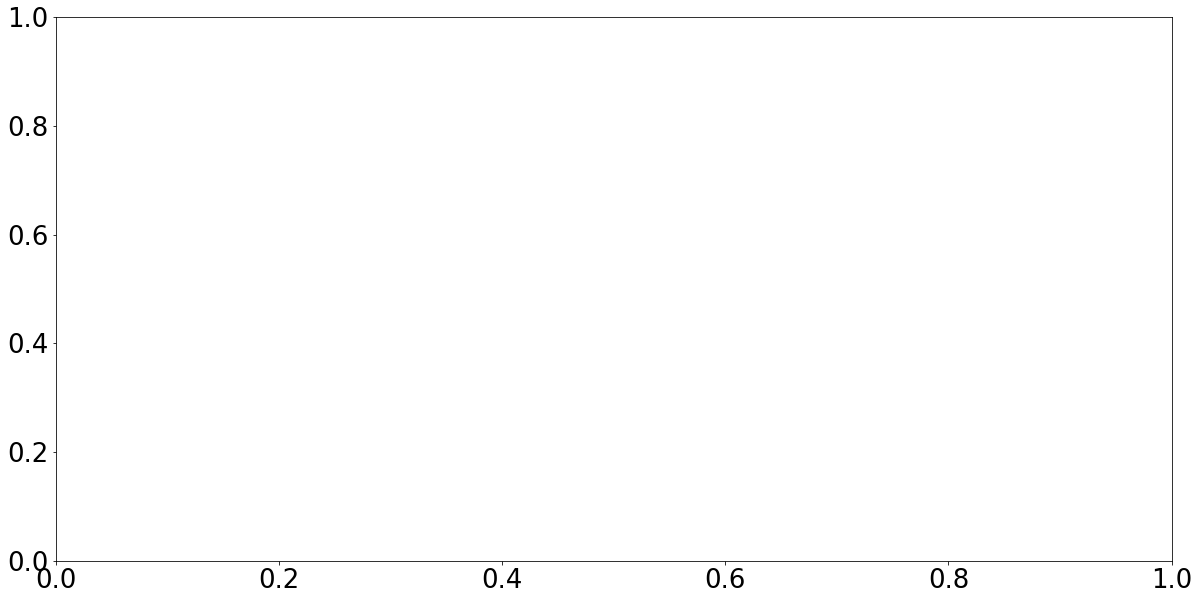

In [30]:
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = 20, 10
plt.rcParams['lines.markersize'] = 30
plt.rcParams['lines.linewidth'] = 5

fig, ax = plt.subplots()

for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
    
# summarize history for accuracy   
plt.plot(recall, prec)
plt.title('model accuracy', fontsize = 26)
plt.ylabel('precision', fontsize = 26)
plt.xlabel('recall', fontsize = 26)
plt.show()

fig, ax = plt.subplots()
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(26) 
    
# summarize history for loss
plt.plot(LeNet.history.history['loss'])
plt.plot(LeNet.history.history['val_loss'])
plt.title('model loss', fontsize = 26)
plt.ylabel('loss', fontsize = 26)
plt.xlabel('epoch', fontsize = 26)
plt.legend(['train', 'test'], loc='upper left', fontsize = 26)
plt.show()